In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

#### Data load

In [2]:
data_input = pd.read_csv('./Ankieta.csv')
data_input.head()

,Waga,Wzrost,Plec
0,55,160,Kobieta
1,78,180,Mezczyzna
2,55,150,Kobieta
3,99,196,Mezczyzna
4,90,180,Mezczyzna


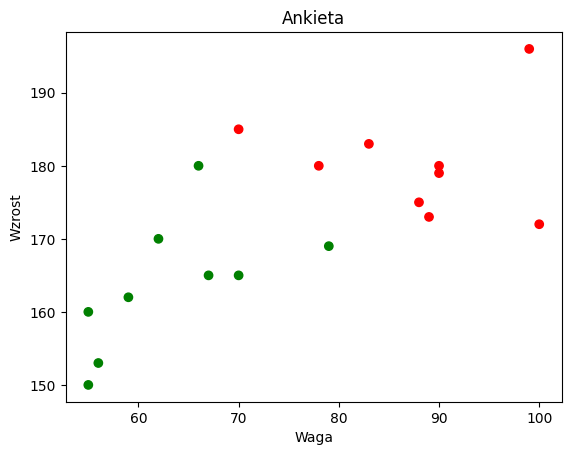

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors

x = data_input['Plec'].map(lambda x: 1 if x == 'Kobieta' else 0)
y = data_input['Waga']
z = data_input['Wzrost']

data_input['Plec'] = data_input['Plec'].map(lambda x: 1 if x == 'Kobieta' else 0)

plt.scatter(y, z, c=x, cmap=colors.ListedColormap(['red', 'green']))
plt.xlabel('Waga')
plt.ylabel('Wzrost')
plt.title('Ankieta')
plt.show()

/tmp/ipykernel_44958/1618543461.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_input.hist(ax=ax)


array([[<Axes: title={'center': 'Waga'}>,
        <Axes: title={'center': 'Wzrost'}>],
       [<Axes: title={'center': 'Plec'}>, <Axes: >]], dtype=object)

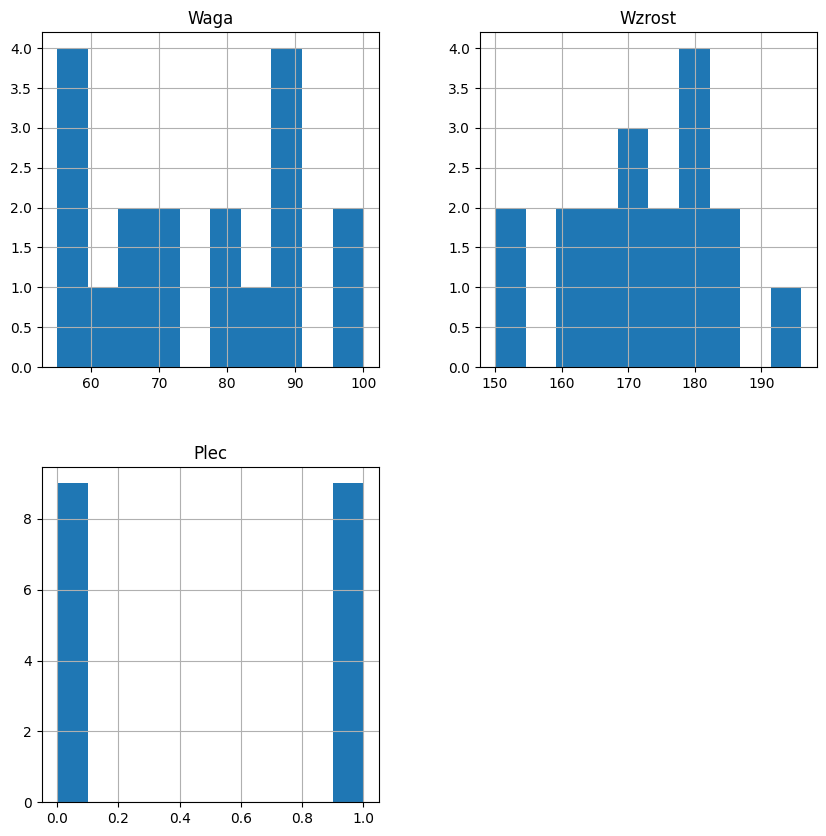

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
data_input.hist(ax=ax)

<Axes: >

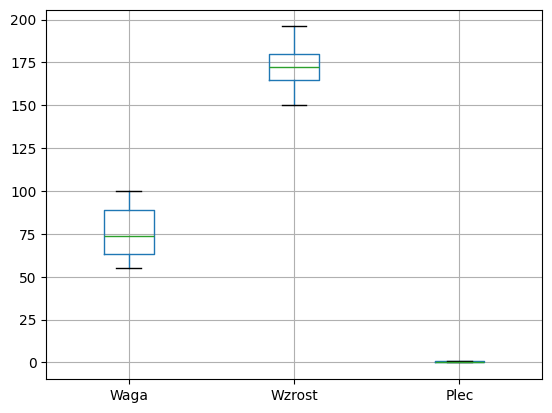

In [5]:
data_input.boxplot()

#### Data scaling

<Axes: >

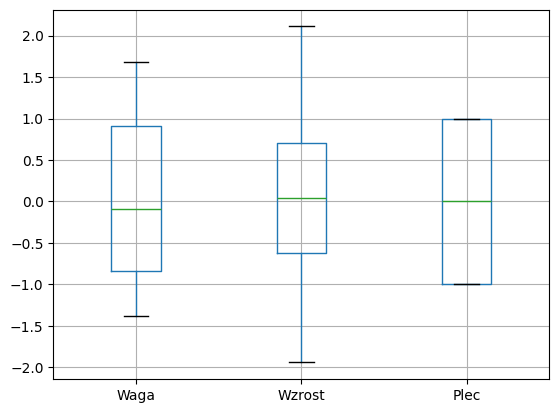

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_input), index = data_input.index, columns = data_input.columns)

data_scaled.boxplot()

#### Dataset split

In [7]:
from sklearn.model_selection import train_test_split
random_state = 23

X = data_input[['Wzrost', 'Waga']].values
y = data_input[['Plec']].values.ravel()

X_scaled = data_scaled[['Wzrost', 'Waga']].values
y_scaled = data_scaled[['Plec']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=random_state)

#### Model training

In [8]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)
print(f"Dokładność przed skalowaniem: {svc.score(X_test, y_test):.2f}")

svc.fit(X_train_scaled, y_train_scaled)
print(f"Dokładność po skalowaniu: {svc.score(X_test_scaled, y_test_scaled):.2f}")

Dokładność przed skalowaniem: 0.75
Dokładność po skalowaniu: 1.00


#### Decision boundary

In [9]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_boundary(kernel):
    plt.figure(figsize=(16, 10))
    
    for i, C in enumerate(np.arange(0.5, 8.5, 0.5)):
        
        svc = SVC(C=C, kernel=kernel).fit(X_train_scaled, y_train_scaled)
        
        decision_function = svc.decision_function(X_train_scaled)
        support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
        support_vectors = X_train_scaled[support_vector_indices]
    
        plt.subplot(4, 4, i + 1)
        plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_scaled)
        ax = plt.gca()
        
        DecisionBoundaryDisplay.from_estimator(svc, X_train_scaled, ax=ax, grid_resolution=50, plot_method="contour",
            **{"colors": "k", "levels": [-1, 0, 1], "alpha": 0.5, "linestyles": ["--", "-", "--"]})
        
        plt.scatter(
            support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors="none", edgecolors="k"
        )
        
        plt.title("C=" + str(round(C, 1)) + "  Acc=" + str(svc.score(X_test_scaled, y_test_scaled)))
    
    plt.tight_layout()
    plt.show()

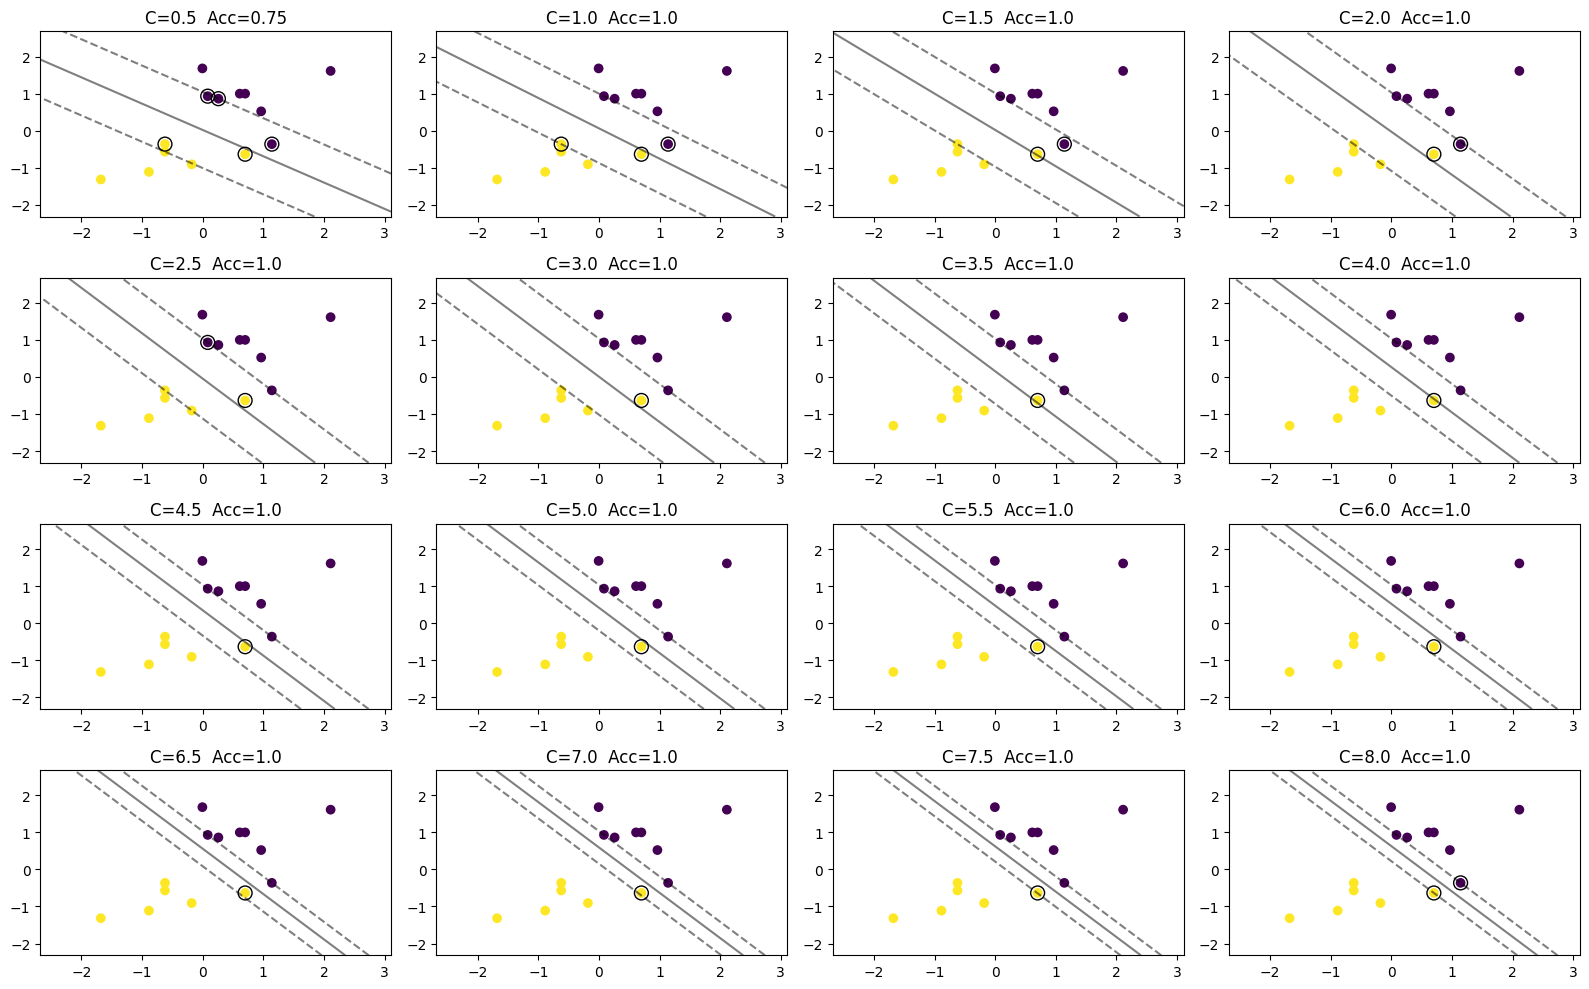

In [10]:
plot_decision_boundary('linear')

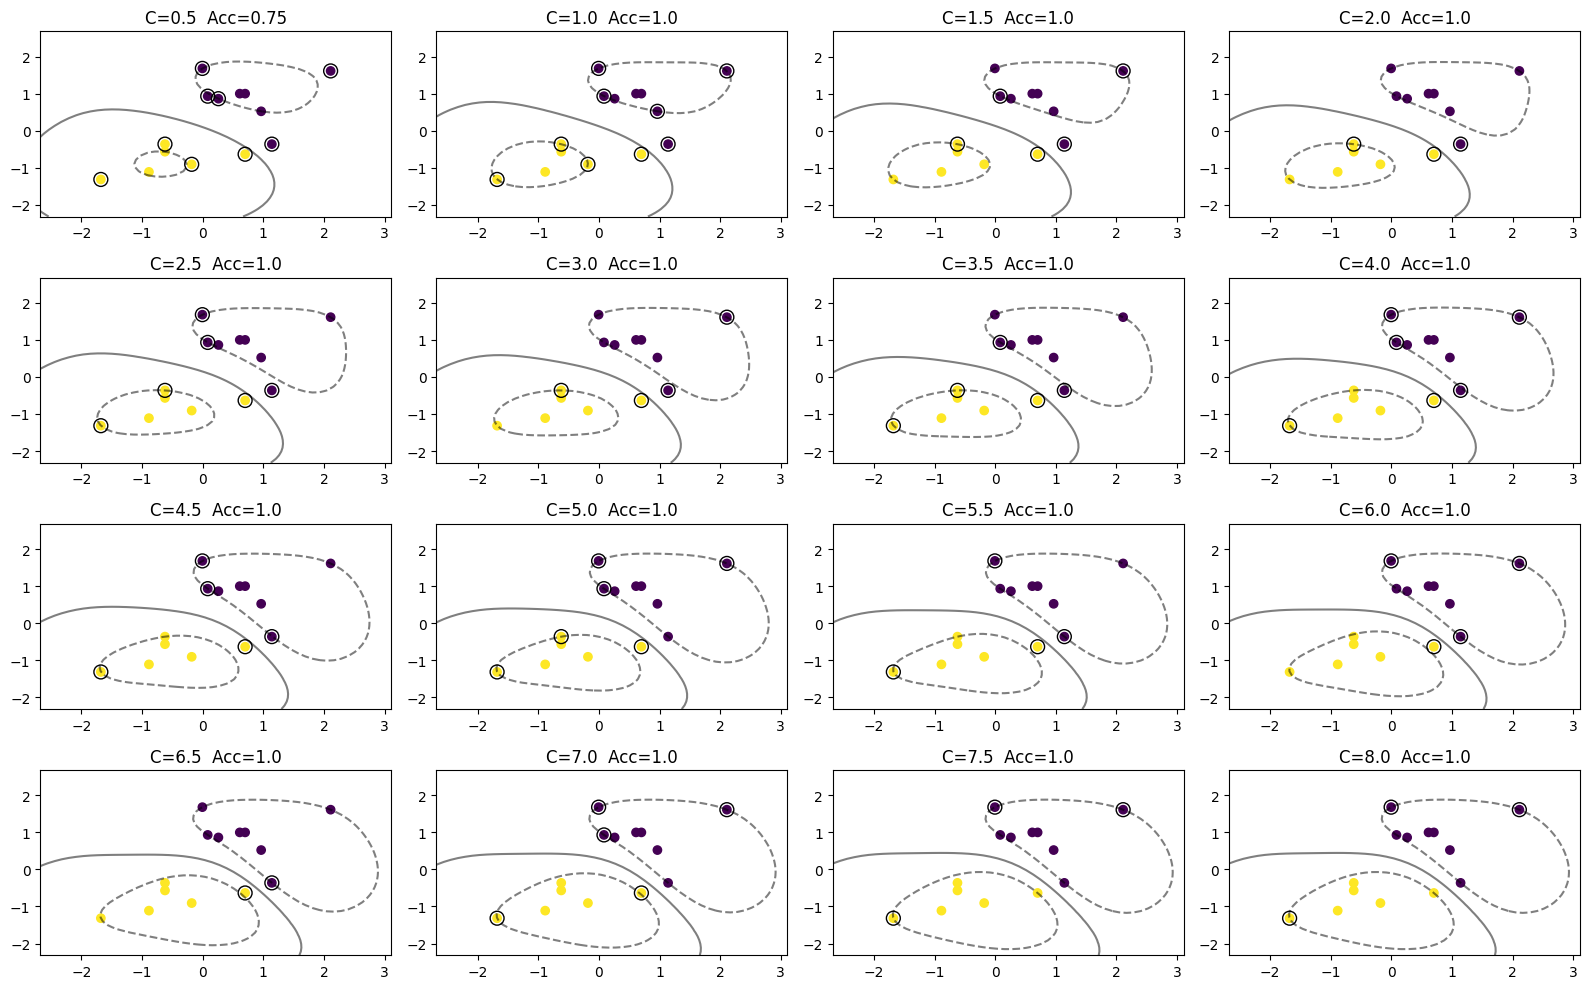

In [11]:
plot_decision_boundary('rbf')

#### Time comparison

In [12]:
print("Linear kernel")
%timeit SVC(kernel='linear').fit(X_scaled, y_scaled)

print("RBF kernel")
%timeit SVC(kernel='rbf').fit(X_scaled, y_scaled)

print("Poly kernel")
%timeit SVC(kernel='poly').fit(X_scaled, y_scaled)

print('Sigmoid kernel')
%timeit SVC(kernel='sigmoid').fit(X_scaled, y_scaled)

Linear kernel
327 μs ± 22.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
RBF kernel
331 μs ± 14.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Poly kernel
357 μs ± 57.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sigmoid kernel
314 μs ± 6.46 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Another dataset

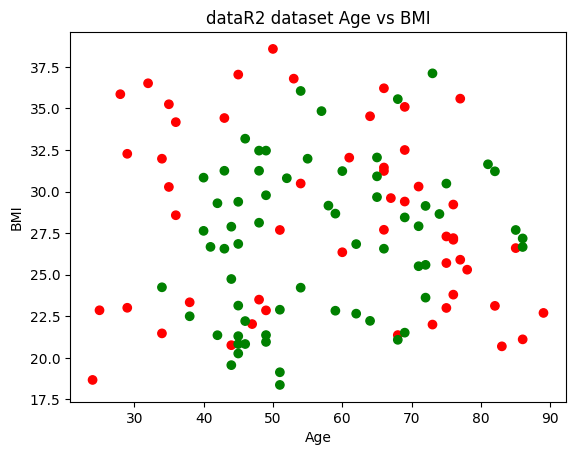

In [13]:
from ucimlrepo import fetch_ucirepo

breast_cancer_coimbra = fetch_ucirepo(id=451)

X = np.array([breast_cancer_coimbra.data.features['Age'].to_numpy(), breast_cancer_coimbra.data.features['BMI'].to_numpy()]).T
y = breast_cancer_coimbra.data.targets.to_numpy()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['red', 'green']))

plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('dataR2 dataset Age vs BMI')

plt.show()

In [14]:
X_scaled = scaler.fit_transform(X)

Kernel: linear: 100%|█████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


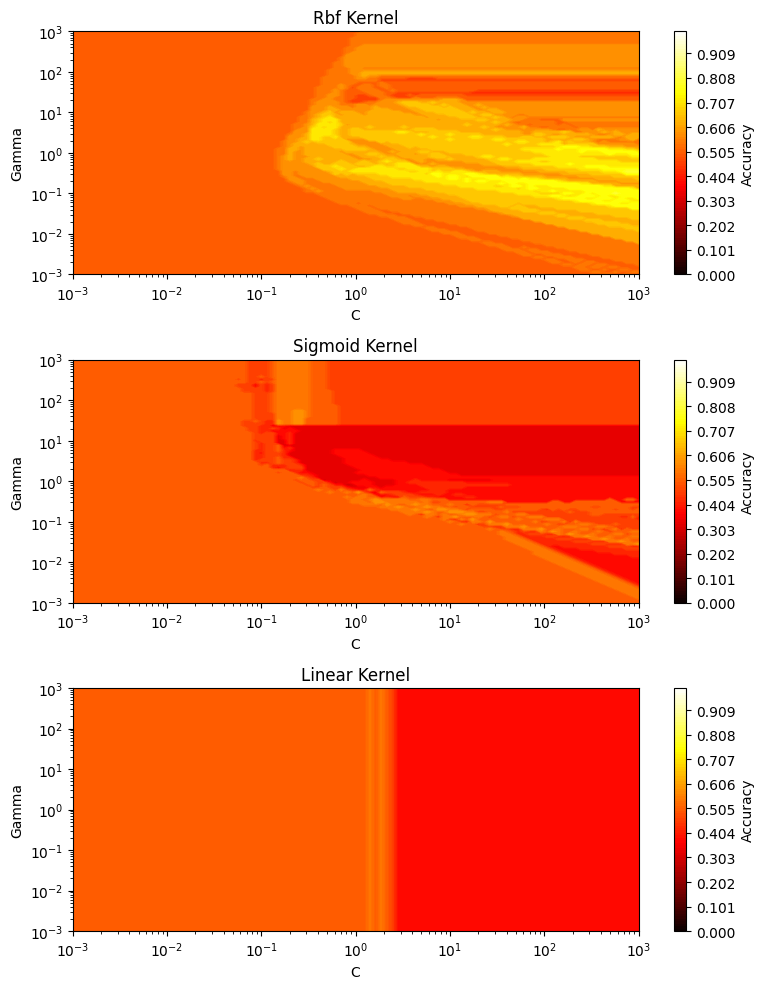

In [15]:
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.ravel(), test_size=0.2, random_state=42)

# kernels = ['rbf', 'sigmoid', 'poly', 'linear']
kernels = ['rbf', 'sigmoid', 'linear']

C_values = np.logspace(-3, 3, 100)
gamma_values = np.logspace(-3, 3, 100)
acc = np.empty((len(C_values), len(gamma_values)))

plt.figure(figsize=(8, 10))

best_configuration = dict()
max_acc = 0.0
for i, kernel in enumerate(kernels):
    plt.subplot(3, 1, i + 1)

    for i, C in enumerate(tqdm(C_values, desc=f'Kernel: {kernel}')):
        for j, gamma in enumerate(gamma_values):
            svc = SVC(kernel=kernel, C=C, gamma=gamma).fit(X_train, y_train)
            accuracy = svc.score(X_test, y_test)
            if accuracy > max_acc:
                max_acc = accuracy
                best_configuration = dict(kernel=kernel, C=C, gamma=gamma)
            acc[j, i] = svc.score(X_test, y_test)
    
    plt.contourf(C_values, gamma_values, acc, levels=np.linspace(0.0, 1.0, 100), vmin = 0.0, vmax = 1, cmap='hot')
    
    plt.colorbar(label='Accuracy')
    plt.xlabel('C')
    plt.ylabel('Gamma')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{kernel.capitalize()} Kernel')
    
plt.tight_layout()
plt.show()

In [16]:
print('Best accuracy:')
print(max_acc)
print("Best configuration:")
print(best_configuration)

Best accuracy:
0.7916666666666666
Best configuration:
{'kernel': 'rbf', 'C': 572.236765935022, 'gamma': 0.09999999999999999}


#### Confusion matrix

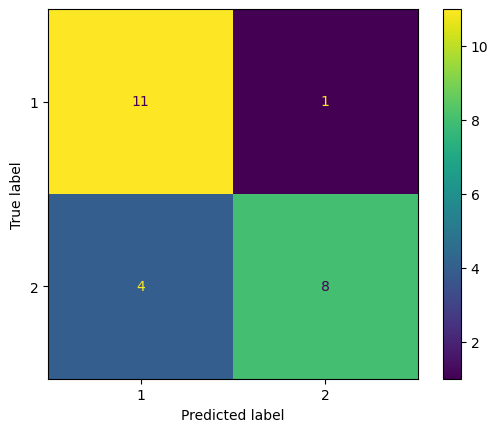

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

svc = SVC(kernel=best_configuration['kernel'], C=best_configuration['C'], gamma=best_configuration['gamma'])

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
plt.show()